In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Qestion 1)

The question asks us to solve (via the relaxation method) the electric field of a charged spherical cylinder. In 2D this would look like a circular cross section. Let's assume it is inside a box where the walls are grounded at zero potential.

'\n#mask[ n//2:n//2+n//16, n//2-n//8:n//2+n//8]=True #what cells in grid to apply to (rod in center)\n#bc[n//2:n//2+n//16,n//2-n//8:n//2+n//8]=1.0 #positive potential\n\nfor i in range(100): \n    sharp = 5.0 #Keep in range (0,4) where 0 is a bar and 4 is a sharp cone. Use >4 for two sources\n    mask[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i ]=True #what cells in grid to apply to (cone at end)\n\n    if n//2 < int(i*sharp):\n        bc[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i]=-1.0 #negative potential or ground\n    else:\n        bc[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i]=1.0 #positive potential\n'

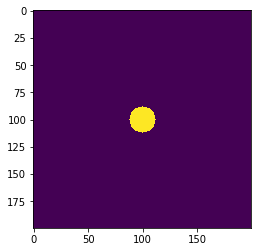

In [43]:
#First, let's start with the geometry. Let's do it in 2D

n_res=200 #resolution of grid

MaxIter = 30*n_res #max number of iterations before stopping
ThresholdResid = 1e-15 #Threshold to hit to deem acceptable

mask=np.zeros([n_res,n_res],dtype='bool')

def wall_bc(bc, mask, val=0.0):
    mask[:,0]=True
    mask[:,-1]=True
    mask[0,:]=True
    mask[-1,:]=True
    bc[mask] = val
    return bc.copy(), mask.copy()



def circle_bc(bc, mask, val=1.0):
    
    center=[bc.shape[0]//2, bc.shape[1]//2]
    radius = bc.shape[0]//16
    
    for i in range(bc.shape[0]):
        for j in range(bc.shape[1]):
            if (((i-center[0])**2 + (j-center[1])**2) <= radius**2):
                bc[i,j] = val
                mask[i,j] = True
    
    #print(pot_grid)
    return bc.copy(), mask.copy()

def bump_bc(bc, mask, bumprad=0.1, val=1.0):
    
    center=[bc.shape[0]//2+bc.shape[0]//16, bc.shape[1]//2]
    radius = np.round(0.2*bc.shape[1]/16.0) #So 10% sticks out
    print('bump radius: ', radius)
    
    for i in range(bc.shape[0]):
        for j in range(bc.shape[1]):
            if (((i-center[0])**2 + (j-center[1])**2) <= radius**2):
                bc[i,j] = val
                mask[i,j] = True
    
    #print(pot_grid)
    return bc.copy(), mask.copy()


#The potential matrix
V=np.zeros([n_res,n_res]) 

#Boundary condition says all walls are grounded

bc = wall_bc(V, mask, 0.0)[0]
bc =circle_bc(bc, mask, 1.0)[0]

V[mask] = bc[mask]

plt.imshow(V)

#Some more interesting geometry for fun
'''
#mask[ n//2:n//2+n//16, n//2-n//8:n//2+n//8]=True #what cells in grid to apply to (rod in center)
#bc[n//2:n//2+n//16,n//2-n//8:n//2+n//8]=1.0 #positive potential

for i in range(100): 
    sharp = 5.0 #Keep in range (0,4) where 0 is a bar and 4 is a sharp cone. Use >4 for two sources
    mask[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i ]=True #what cells in grid to apply to (cone at end)

    if n//2 < int(i*sharp):
        bc[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i]=-1.0 #negative potential or ground
    else:
        bc[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i]=1.0 #positive potential
'''


In [44]:
#Relaxation method
def relaxation(V, MaxIter=30*n_res):
    residual_relax = 1.0
    i=0
    while(i<MaxIter and residual_relax > ThresholdResid):
        V[1:-1,1:-1]=(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0 #average neighbours
        

        V[mask] = bc[mask]
        
        if i>0:
            residual_relax = np.sum((V-V_old)**2.) #not really the residual but wtv
        
        V_old = V.copy()

        if i%1000==0:
            print("On iteration", i, " the residual is %.2e"%residual_relax)
        i+=1

    if i<MaxIter:
        print("Achieved threshold tolerance after ", i, " iterations")
    elif i>=MaxIter:
        print("Reached maximum number of iterations achieving tolerance of ", residual_relax)

    numIter_relax = i

    rho=V[1:-1,1:-1]-(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0 #The charge
    
    return V, rho, i, residual_relax



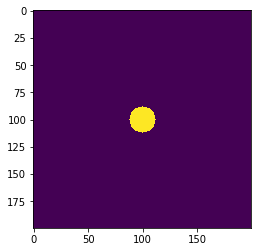

('On iteration', 0, ' the residual is 1.00e+00')
('On iteration', 1000, ' the residual is 1.53e-04')
('On iteration', 2000, ' the residual is 5.79e-05')
('On iteration', 3000, ' the residual is 3.16e-05')
('On iteration', 4000, ' the residual is 1.90e-05')
('On iteration', 5000, ' the residual is 1.17e-05')
('Reached maximum number of iterations achieving tolerance of ', 7.212827162483507e-06)


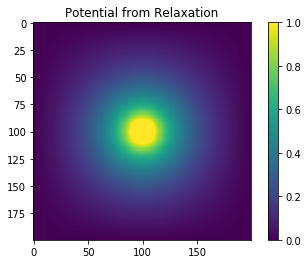

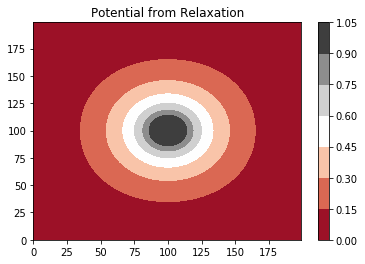

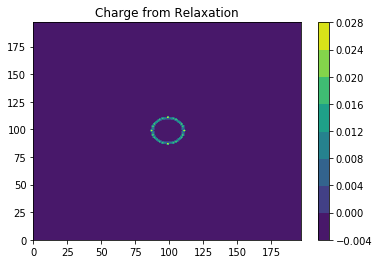

In [19]:
plt.imshow(V)
plt.show()

V_relax, rho_relax, iter_relax, residual_relax = relaxation(V, MaxIter)

plt.imshow(rho_relax) #charge should only be on the conductor surface!
plt.colorbar()

    

plt.clf()
plt.imshow(V_relax)
plt.title('Potential from Relaxation')
plt.colorbar()
plt.show()
plt.clf()
plt.contourf(V_relax, cmap='RdGy')
plt.title('Potential from Relaxation')
plt.colorbar()
plt.show()
#plt.imshow(rho, vmin=0.1, vmax=0.12)
plt.contourf(rho_relax)
plt.title('Charge from Relaxation')
plt.colorbar()
plt.show()

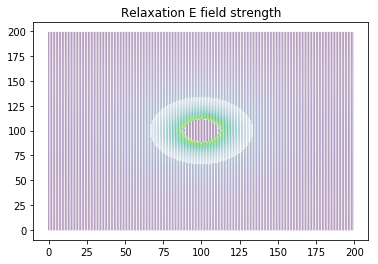

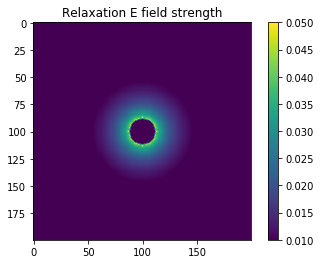

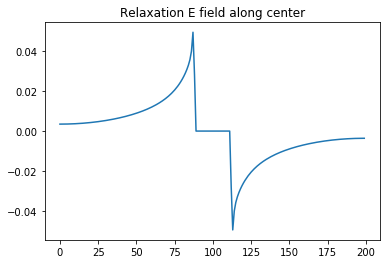

In [20]:
#Plot the electric field
skip=1 #why can't I skip values???
R = np.sqrt(np.gradient(V_relax,1.0)[0]**2. + np.gradient(V_relax,1.0)[1]**2.)
plt.quiver(np.arange(0,n_res)[::skip], np.arange(0,n_res)[::skip],np.gradient(V_relax, 1.0)[0][::skip], np.gradient(V_relax, 1.0)[1][::skip],R[::skip],  color='0.5', 
           units='height', scale=1.0/0.25, pivot='mid')
plt.title('Relaxation E field strength')
plt.show()

plt.clf()
plt.imshow(np.sqrt(np.gradient(V_relax,1.0)[0]**2. + np.gradient(V_relax,1.0)[1]**2.), vmin=0.01, vmax=0.05)
plt.colorbar()
plt.title('Relaxation E field strength')
plt.show()


plt.clf()
plt.title('Relaxation E field along center')
plt.plot(np.arange(n_res),np.gradient(V_relax[:,n_res//2]))


## Quetion 2) 

Now let's go for the conjugate gradient approach...

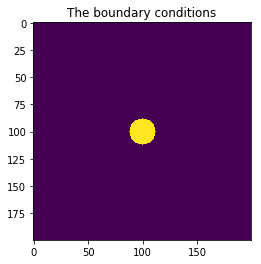

on iteration 0 residual is 4.51e+02
('Surpassed maximum relaxation residual after', 217, ' iterations.')
('Same tolerance achieved in ', 0.036166666666666666, 'the number of iterations')
on iteration 1000 residual is 1.27e-13
('Achieved threshold tolerance of ', 1e-15, ' after ', 1995, ' iterations')


In [21]:
#print('residual relax is '+repr(residual_relax))

def Ax(V,mask):
    
    Vuse=V.copy()
    Vuse[mask]=0
    ans=(Vuse[1:-1,:-2]+Vuse[1:-1,2:]+Vuse[2:,1:-1]+Vuse[:-2,1:-1])/4.0
    ans=ans-V[1:-1,1:-1]
    
    return ans

def conj_grad(V, MaxIter, mask, bc):
    
    b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
    
    #print('b shape is '+repr(b.shape))
    
    b[mask[1:-1, 1:-1]] = 0

    r=b-Ax(V,mask)
        
    p=r.copy()

    residual_conj=1.0  
    surpass=False
    i=0
    
    while(i<MaxIter and residual_conj > ThresholdResid):
        V[mask] = bc[mask]
            
        if( (residual_conj<residual_relax) and (surpass==False)):
            print("Surpassed maximum relaxation residual after", i, " iterations.")
            print("Same tolerance achieved in ",float(i)/float(iter_relax), "the number of iterations")
            surpass = True

        Ap=(Ax(np.pad(p, (1,1), mode='constant'),mask))
                
        residual_conj=np.sum(r*r)
        
        if i%1000 == 0:
            print('on iteration ' + repr(i) + ' residual is %.2e'%residual_conj)
    
        alpha=residual_conj/np.sum(Ap*p)

        V=V+np.pad(alpha*p, (1,1), mode='constant')
        rnew=r-alpha*Ap
        beta=np.sum(rnew*rnew)/residual_conj
        p=rnew+beta*p
        r=rnew
        i+=1
        
    rho=V[1:-1,1:-1]-(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0
    return V,rho, i



#Let's try it out
mask2=np.zeros([n_res,n_res],dtype='bool')

#The potential matrix
V2=np.zeros([n_res,n_res]) 

#Boundary condition says all walls are grounded, circle has potential = +1
bc2, mask2 = wall_bc(V2, mask2, 0.0)
bc2, mask2 =circle_bc(bc2, mask2, 1.0)

V2[mask2] = bc2[mask2] #setting potential to BC

plt.imshow(bc2)
plt.title('The boundary conditions')
plt.show()

V_conj, rho_conj, iter_conj = conj_grad(V2, MaxIter, mask2, bc2) #Let's roll

if iter_conj<MaxIter:
    print("Achieved threshold tolerance of ",ThresholdResid," after ", iter_conj, " iterations")
else:
    print("Reached maximum number of iterations")

    

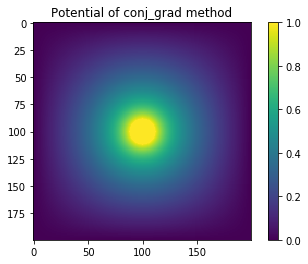

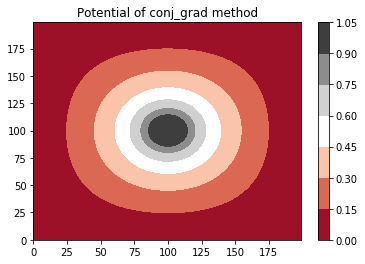

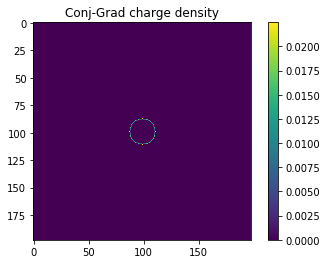

In [22]:
plt.clf()
plt.imshow(V_conj)
plt.title('Potential of conj_grad method')
plt.colorbar()
plt.show()

plt.clf()
plt.contourf(V_conj, cmap='RdGy')
plt.title('Potential of conj_grad method')
plt.colorbar()
plt.show()

plt.clf();
plt.imshow(rho_conj)
plt.title('Conj-Grad charge density')
plt.colorbar()
plt.show()

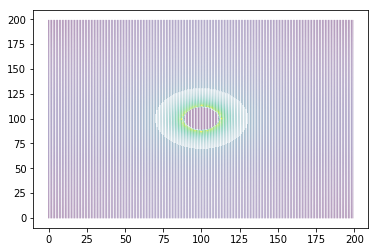

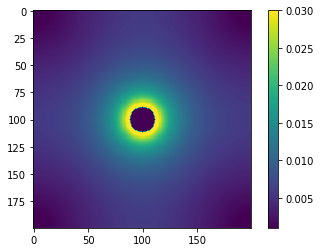

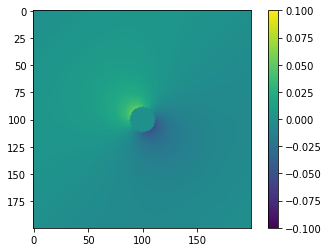

In [71]:
#Plot the electric field
skip=1 #why can't I skip values???
R = np.sqrt(np.gradient(V_conj,1.0)[0]**2. + np.gradient(V_conj,1.0)[1]**2.)
plt.quiver(np.arange(0,n_res)[::skip], np.arange(0,n_res)[::skip],np.gradient(V_conj, 1.0)[0][::skip], np.gradient(V_conj, 1.0)[1][::skip],R[::skip],  color='0.5', 
           units='height', scale=1.0/0.25, pivot='mid')
plt.show()

plt.imshow(np.sqrt(np.gradient(V_conj,1.0)[0]**2. + np.gradient(V_conj,1.0)[1]**2.), vmin=0.001, vmax=0.03)
plt.colorbar()

plt.show()
plt.imshow((np.gradient(V_conj,1.0)[0] + np.gradient(V_conj,1.0)[1]), vmin=-0.1, vmax=0.1)
plt.colorbar()

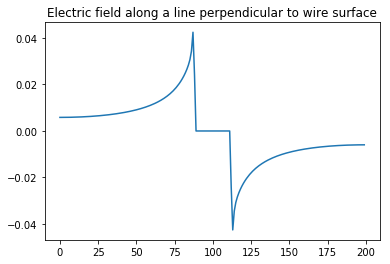

The field is constant in the conductor (phewh)
It's looking alright, going from 1/r -> 1/r^2 as you move away


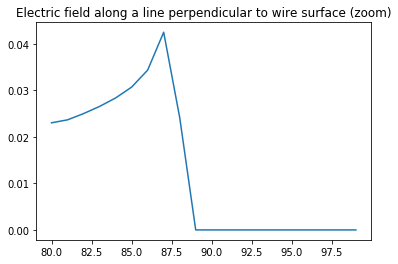

In [83]:
plt.clf()
plt.title('Electric field along a line perpendicular to wire surface')
plt.plot(np.arange(n_res),np.gradient(V_conj[:,n_res//2]))
plt.show()

plt.clf()
plt.title('Electric field along a line perpendicular to wire surface (zoom)')
plt.plot(np.arange(n_res)[80:100],np.gradient(V_conj[80:100,n_res//2]))

print('The field is constant in the conductor (phewh)')
print("It's looking alright, going from 1/r -> 1/r^2 as you move away")

# Question 3) 

Upscaling the resolution...

In [24]:
#Let's take the solution we have now and iteratively double the resolution. 
from scipy.interpolate import griddata

def better_res(V, MaxRes, IterRes=0, scaleFactor=2):    
    V_new = np.zeros([V.shape[0], V.shape[1]])
    
    plt.imshow(V)
    plt.title('This is V!')
    plt.show()
    
    curr_res = V.shape[0]
    V_temp = V.copy()
    
    while curr_res<MaxRes:  
        
        old_res = V_temp.shape[0]
        
        new_res = V_temp.shape[0]*scaleFactor
        
        size_old = np.linspace(0, old_res, old_res)
        
        size_new = np.linspace(0, old_res, new_res)
        
        xx,yy = np.meshgrid(size_new,size_new)
        
        x,y = np.meshgrid(size_old, size_old)
        
        points = np.array([x.ravel(),y.ravel()]).transpose()
        V_temp = V_temp.ravel() 
        V_new = griddata(points, V_temp, (xx,yy)) #interpolate to new resolution
        
        
        #Let's try it out
        mask_new=np.zeros([new_res,new_res],dtype='bool')

        #Boundary condition says all walls are grounded, circle has potential = +1
        bcv = np.zeros([new_res, new_res])
        bc_new, mask_new = wall_bc(bcv, mask_new, 0.0)
        bc_new, mask_new = circle_bc(bc_new, mask_new, 1.0)
        
        
        #plt.imshow(bc_new)
        #plt.title('The boundary condition')
        #plt.show()

        V_new[mask_new] = bc_new[mask_new] #setting potential to BC
        
        #plt.imshow(V_new)
        #plt.title('After BC is reset')
        #plt.show()

        V_new, rho_new, iter_conj = conj_grad(V_new, MaxIter, mask_new, bc_new) #Let's roll
        
        IterRes+=iter_conj
    
        plt.clf()
        plt.imshow(V_new)
        plt.title('This is V_new')
        plt.show()
        
        V_temp = V_new
        curr_res = new_res
    
    
    return V_new, IterRes
    


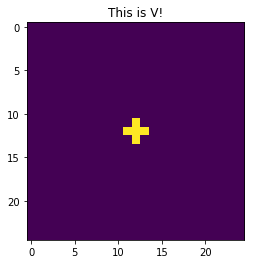

on iteration 0 residual is 2.74e+01
('Surpassed maximum relaxation residual after', 63, ' iterations.')
('Same tolerance achieved in ', 0.0105, 'the number of iterations')


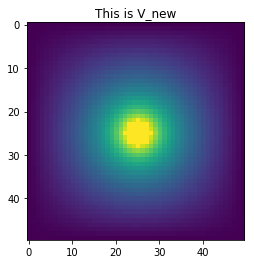

on iteration 0 residual is 9.42e+01
('Surpassed maximum relaxation residual after', 30, ' iterations.')
('Same tolerance achieved in ', 0.005, 'the number of iterations')


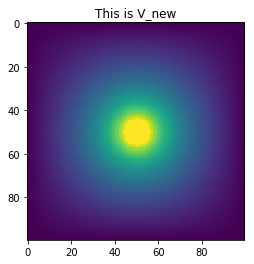

on iteration 0 residual is 4.03e+02
('Surpassed maximum relaxation residual after', 25, ' iterations.')
('Same tolerance achieved in ', 0.004166666666666667, 'the number of iterations')


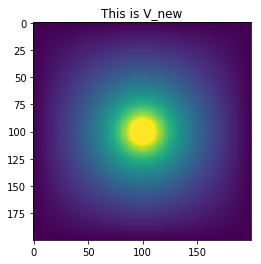

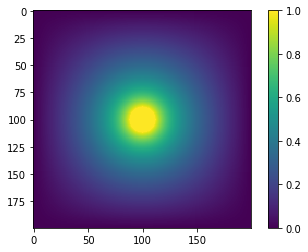

The resolution method took: 1069 steps
The conjugate gradient method took: 1995 steps
The relaxation method took: 6000 steps, and never acheieved tolerance.


In [25]:
MaxRes = n_res

res_start = 25

#Let's try it out
mask3=np.zeros([res_start,res_start],dtype='bool')

#The potential matrix
V3=np.zeros([res_start,res_start]) 

#Boundary condition says all walls are grounded, circle has potential = +1
bc3 = wall_bc(V3, mask3, 0.0)[0]
bc3 =circle_bc(bc3, mask3, 1.0)[0]

V3[mask3] = bc3[mask3] #setting potential to BC

V_better, iter_better = better_res(V3, MaxRes)

plt.imshow(V_better)
plt.colorbar()
plt.show()

print('The resolution method took: '+repr(iter_better)+' steps')
print('The conjugate gradient method took: '+repr(iter_conj)+' steps')
print('The relaxation method took: '+repr(iter_relax)+' steps, and never acheieved tolerance.')


# Question 4)

Now let's add our bump and check out the electric field.

In [45]:
def better_res_mod(V, MaxRes, IterRes=0, scaleFactor=2):    
    V_new = np.zeros([V.shape[0], V.shape[1]])
    
    plt.imshow(V)
    plt.title('This is V!')
    plt.show()
    
    curr_res = V.shape[0]
    V_temp = V.copy()
    
    while curr_res<MaxRes:  
        
        old_res = V_temp.shape[0]
        
        new_res = V_temp.shape[0]*scaleFactor
        
        size_old = np.linspace(0, old_res, old_res)
        
        size_new = np.linspace(0, old_res, new_res)
        
        xx,yy = np.meshgrid(size_new,size_new)
        
        x,y = np.meshgrid(size_old, size_old)
        
        points = np.array([x.ravel(),y.ravel()]).transpose()
        V_temp = V_temp.ravel() 
        V_new = griddata(points, V_temp, (xx,yy)) #interpolate to new resolution
        
        
        #Let's try it out
        mask_new=np.zeros([new_res,new_res],dtype='bool')

        #Boundary condition says all walls are grounded, circle has potential = +1
        bcv = np.zeros([new_res, new_res])
        bc_new, mask_new = wall_bc(bcv, mask_new, 0.0)
        bc_new, mask_new = circle_bc(bc_new, mask_new, 1.0)
        bc_new, mask_new = bump_bc(bc_new, mask_new, 1.0)

        
        
        #plt.imshow(bc_new)
        #plt.title('The boundary condition')
        #plt.show()

        V_new[mask_new] = bc_new[mask_new] #setting potential to BC
        
        #plt.imshow(V_new)
        #plt.title('After BC is reset')
        #plt.show()

        V_new, rho_new, iter_conj = conj_grad(V_new, MaxIter, mask_new, bc_new) #Let's roll
        
        IterRes+=iter_conj
    
        plt.clf()
        plt.imshow(V_new)
        plt.title('This is V_new')
        plt.show()
        
        V_temp = V_new
        curr_res = new_res
    
    
    return V_new, IterRes

('bump radius: ', 5.0)


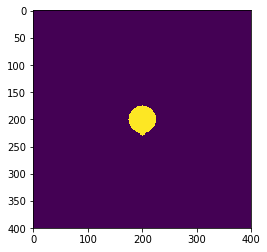

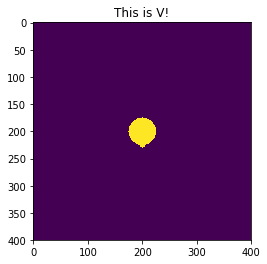

('bump radius: ', 10.0)
on iteration 0 residual is 7.95e+03
('Surpassed maximum relaxation residual after', 693, ' iterations.')
('Same tolerance achieved in ', 0.1155, 'the number of iterations')
on iteration 1000 residual is 3.66e-09


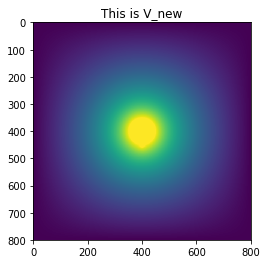

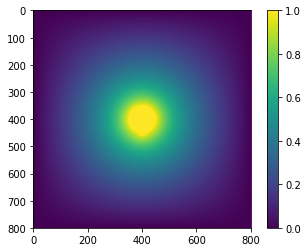

In [46]:
#Let's try it out
res_start = 400
MaxRes = 800
mask4=np.zeros([res_start,res_start],dtype='bool')

#The potential matrix
V4=np.zeros([res_start,res_start]) 

#Boundary condition says all walls are grounded, circle (with bump) has potential = +1
bc4 = wall_bc(V4, mask4, 0.0)[0]
bc4 =circle_bc(bc4, mask4, 1.0)[0]
bc4 =bump_bc(bc4, mask4, 1.0)[0] #Add a bump 10% of wire diameter

V4[mask4] = bc4[mask4] #setting potential to BC

plt.imshow(V4)
plt.show()

V_better_b, iter_better_b = better_res_mod(V4, MaxRes)

plt.imshow(V_better_b)
plt.colorbar()
plt.show()


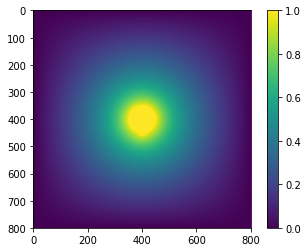

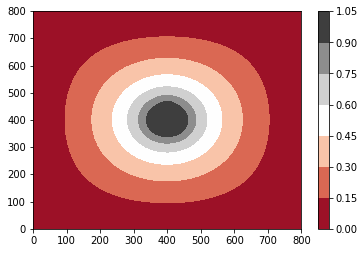

In [47]:
plt.clf()
plt.imshow(V_better_b)
plt.colorbar()
plt.show()
plt.clf()
plt.contourf(V_better_b, cmap='RdGy')
plt.colorbar()
plt.show()

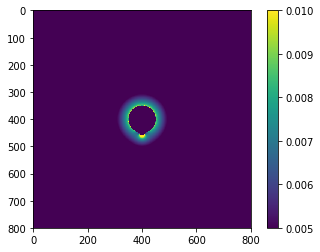

On one side of the wire the electric field is now much stronger, 
 hence losses of power via radiation can be much larger.


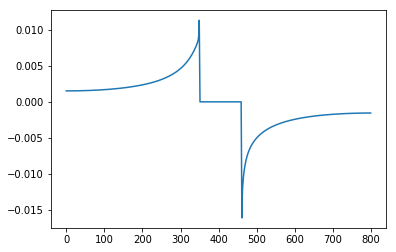

In [84]:
#Plot the electric field
R = np.sqrt(np.gradient(V_better_b,1.0)[0]**2. + np.gradient(V_better_b,1.0)[1]**2.)

plt.imshow(np.sqrt(np.gradient(V_better_b,1.0)[0]**2. + np.gradient(V_better_b,1.0)[1]**2.), vmin=0.005, vmax=0.01)
plt.colorbar()
plt.show()

#plt.show()
#plt.imshow((np.gradient(V_better_b,1.0)[0] + np.gradient(V_better_b,1.0)[1]))
#plt.colorbar()

plt.clf()
plt.plot(np.arange(MaxRes),np.gradient(V_better_b[:,MaxRes//2]))

print('On one side of the wire the electric field is now much stronger, \n hence losses of power via radiation can be much larger.')